In [1]:
using NBInclude
@nbinclude("KIC1430163.ipynb")

General info:                 
Size of the subset:           3518
Mean of the flux:             2.125678e6
Variance of the flux:         209401.3
Variance of the errors:       0.0028263223
Mean of the time differences: 0.026616617260856176
Lomb–Scargle periodogram:
The peak is at 0.2222990081813975.
The relevant estimate of the period is 4.498445621421726.


In [2]:
# Unpack a tuple of parameters
function unpack(θ)
    A = θ[1]
    l = θ[2]
    P = θ[3]
    μ = θ[4]
    σ²ₙ = θ[5]
    return A, l, P, μ, σ²ₙ
end

# Calculate the negative log marginal likelihood
function nlml(θ)
    A, l, P, μ, σ²ₙ = unpack(θ)
    k = A * stretch(Stheno.EQ(), 1 / l^2) * Stheno.Cosine(P / 2)
    g = GP(μ, k, GPC())
    return -logpdf(g(t, σ²ₙ), f)
end
;

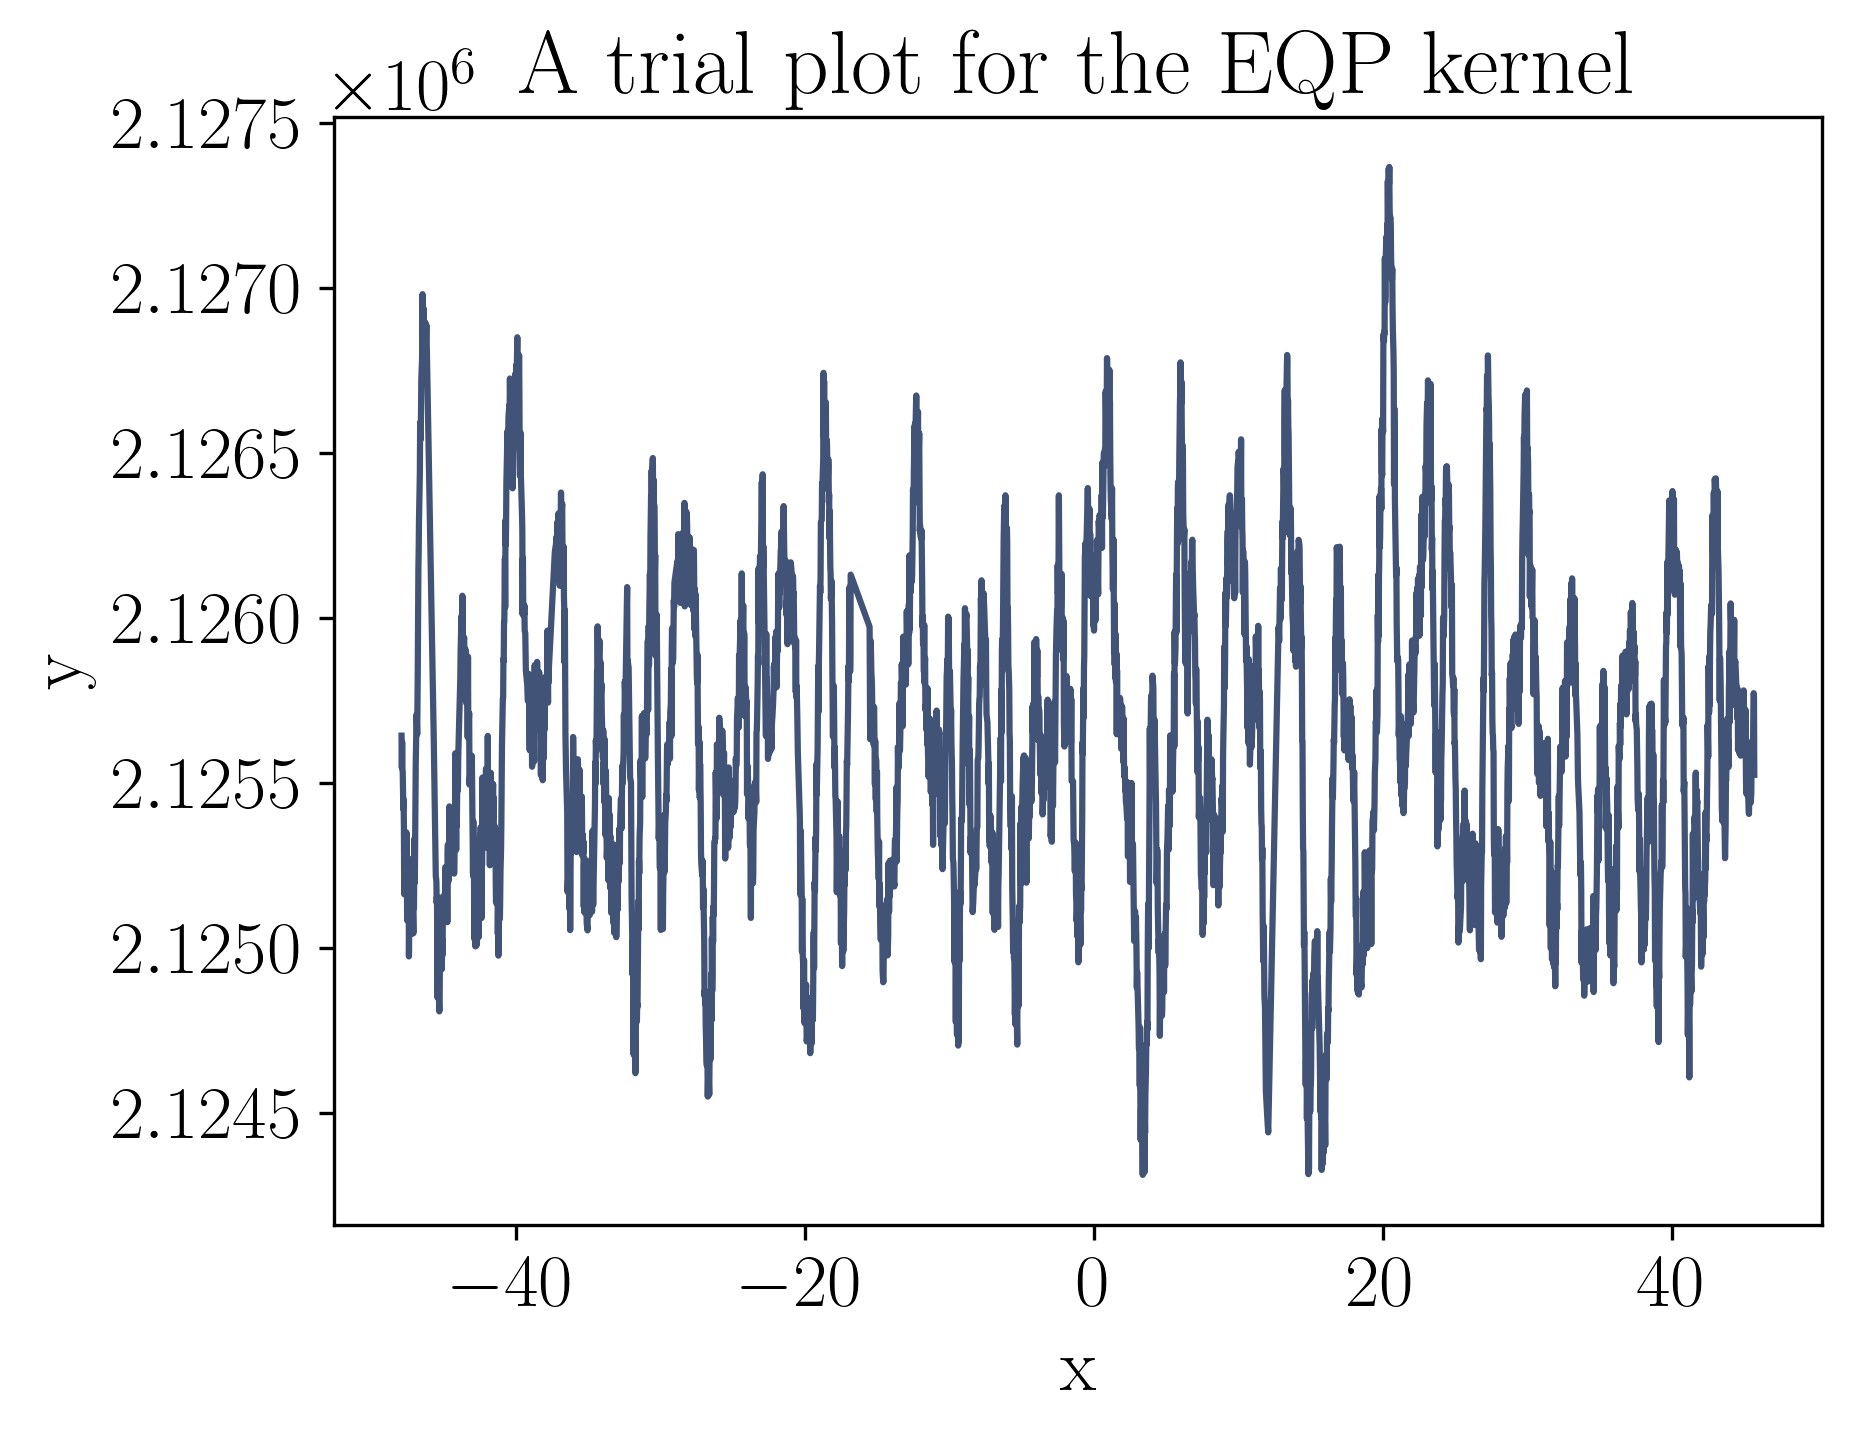

Negative log marginal likelihood: 21253.239040160737


In [3]:
# Select the trial parameters
Aₜ = A₀
lₜ = 0.60
Pₜ = P₀
μₜ = μ₀
σ²ₙₜ = 5500

# Create a kernel
EQP = Aₜ * stretch(Stheno.EQ(), 1 / lₜ^2) * Stheno.Cosine(Pₜ / 2)

# Create a Gaussian process
g = GP(μₜ, EQP, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = t
y = rand(g(x, σ²ₙₜ))

plot(x, y; color)

title(L"\textrm{A trial plot for the EQP kernel}")
xlabel(L"\textrm{x}")
ylabel(L"\textrm{y}")

θ = [Aₜ, lₜ, Pₜ, μₜ, σ²ₙₜ]
println("Negative log marginal likelihood: ", nlml(θ))

In [4]:
# Collect a parameters vector
θ₀ = [A₀, lₜ, P₀, μ₀, σ²ₙₜ]

# Define the lower and upper boundaries, respectively
θₗ = [209000.0, 0.45, 2.5, 2125650.0, 5400.0]
θᵤ = [210000.0, 0.7, 20.0, 2125750.0, 5800.0]

# Optimize the negative log marginal likelihood function
results = Optim.optimize(
    nlml,
    θ->Zygote.gradient(nlml, θ)[1],
    θₗ,
    θᵤ,
    θ₀,
    Fminbox(BFGS()),
    Optim.Options(
        outer_iterations = 1,
        show_trace = true,
        extended_trace = true,
        store_trace = false,
    );
    inplace = false,
)

Fminbox
-------
Initial mu = 0.0884029

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0884029

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.125063e+04     1.517472e+03
 * Current step size: 1.0
 * time: 0.003721952438354492
 * g(x): [-0.0001342239783988097, 1517.4724766781976, 11.980615733681573, 0.0020374753863405216, -0.05181444650741313]
 * ~inv(H): [1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0]
 * x: [209401.296875, 0.6, 4.498445621421726, 2.125678e6, 5500.0]
     1     2.118301e+04     2.293915e+01
 * Current step size: 6.177841401491558e-5
 * time: 283.22564792633057
 * g(x): [0.0001789820291681817, 22.939151842122765, -2.251126501643076, 0.0023788207794700794, -0.012756325538713845]
 * ~inv(H): [0.9999999999999708 2.0954509125695533e-7 1.7983203306260873e-9 1.4239675365650605e-13 -6.446405852480058e-12; 2.0954509125695533e-7 0.00015339324

 * Status: failure (objective increased between iterations)

 * Candidate solution
    Final objective value:     2.118095e+04

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 2.97e+02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.39e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.22e+01 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.41e-03 ≰ 0.0e+00
    |g(x)|                 = 1.32e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   7309  (vs limit Inf)
    Iterations:    1
    f(x) calls:    122
    ∇f(x) calls:   122


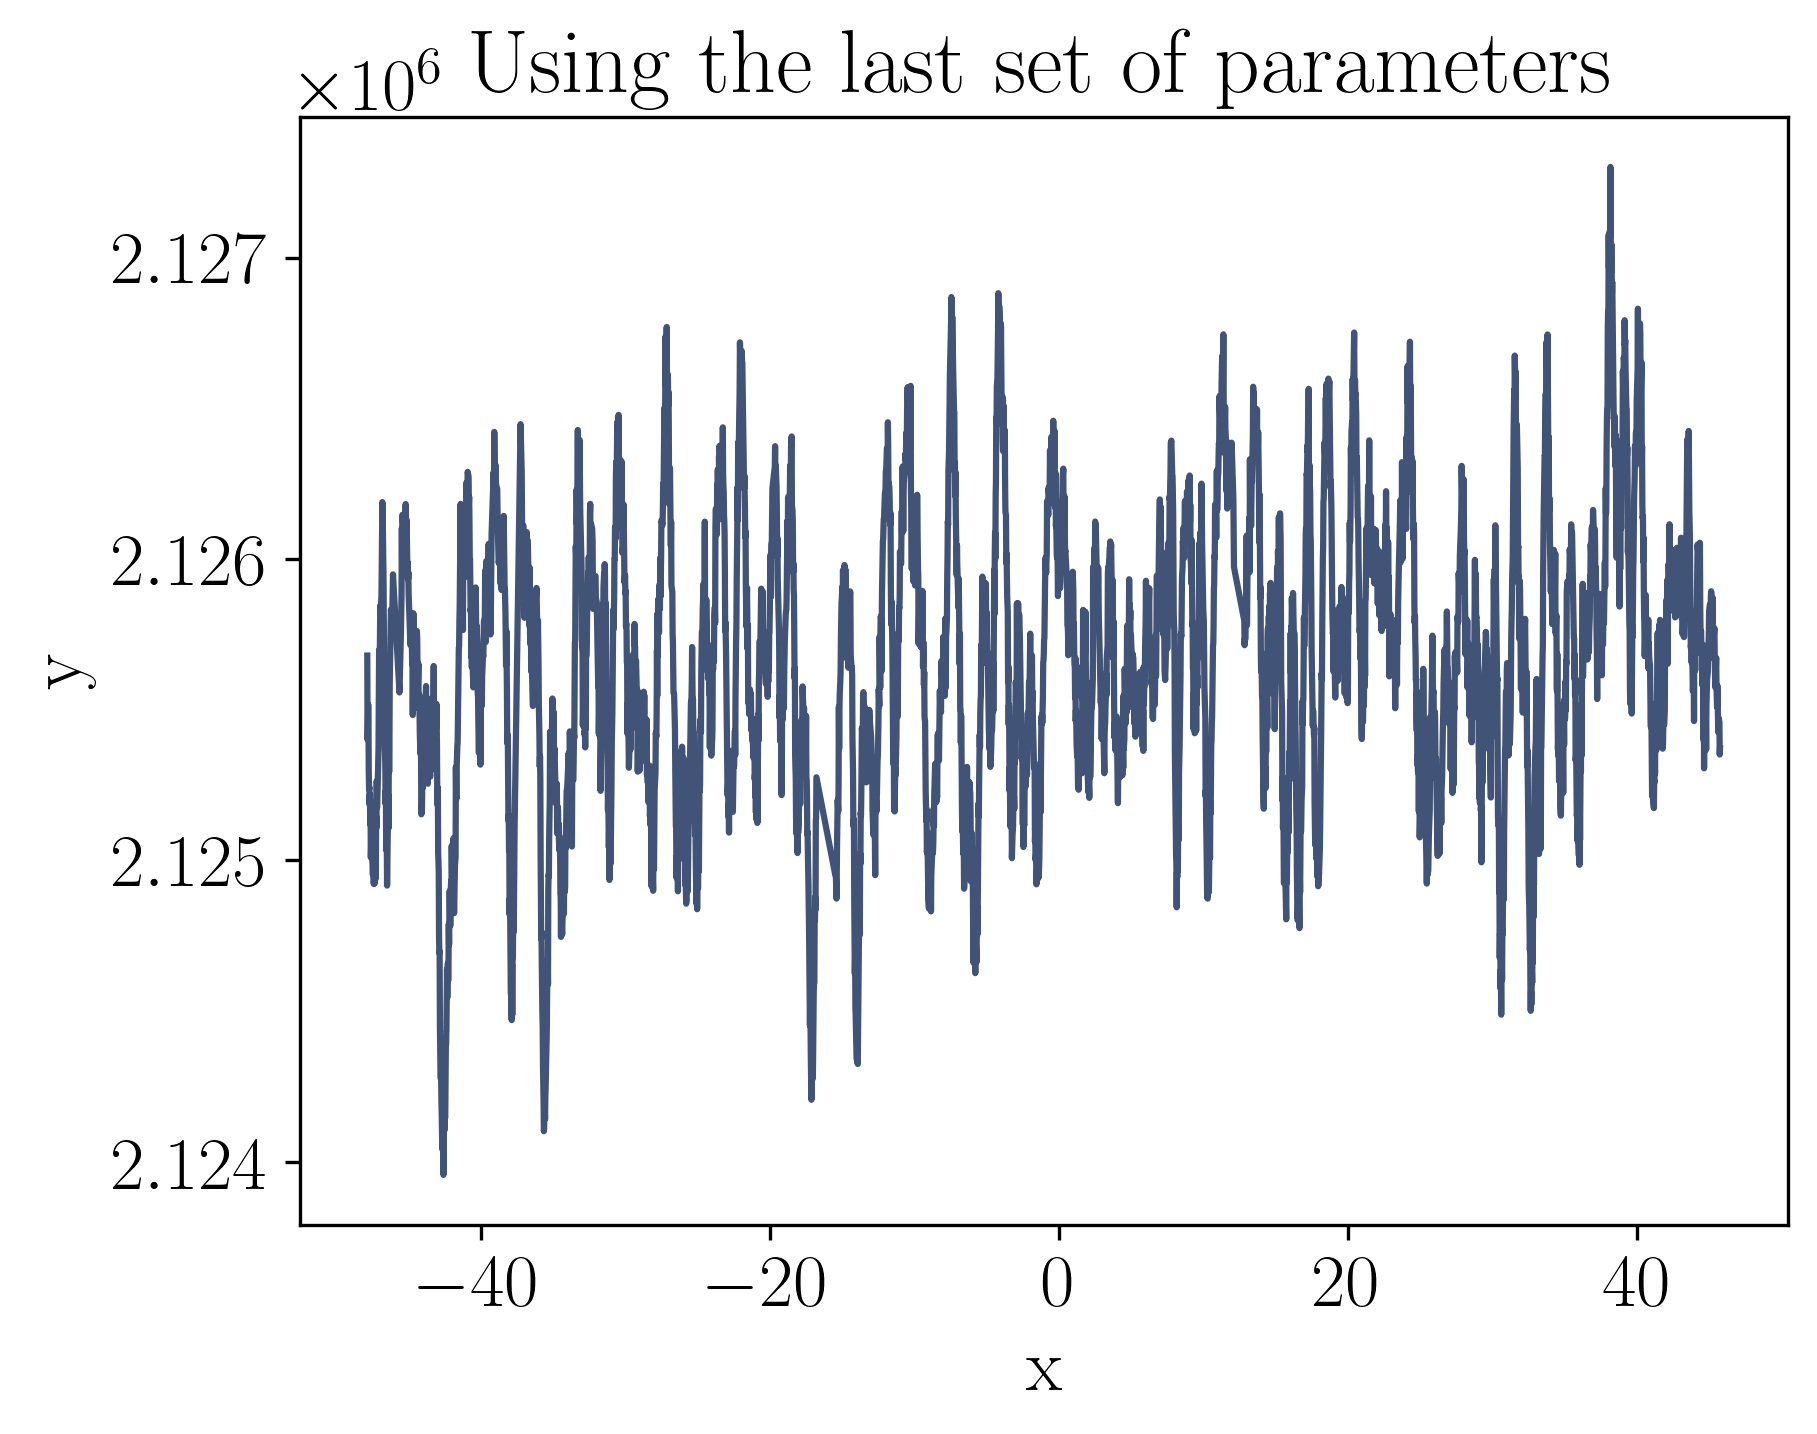

Negative log marginal likelihood: 21180.946475238452


In [8]:
# Take the last set of parameters
θₐ = results.minimizer

# Create a kernel
EQP = θₐ[1] * stretch(Stheno.EQ(), 1 / θₐ[2]^2) * Stheno.Cosine(θₐ[3] / 2)

# Create a Gaussian process
g = GP(θₐ[4], EQP, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = t
y = rand(g(x, θₐ[5]))

close()
plot(x, y; color)

title(L"\textrm{Using the last set of parameters}")
xlabel(L"\textrm{x}")
ylabel(L"\textrm{y}")

println("Negative log marginal likelihood: ", nlml(θₐ))

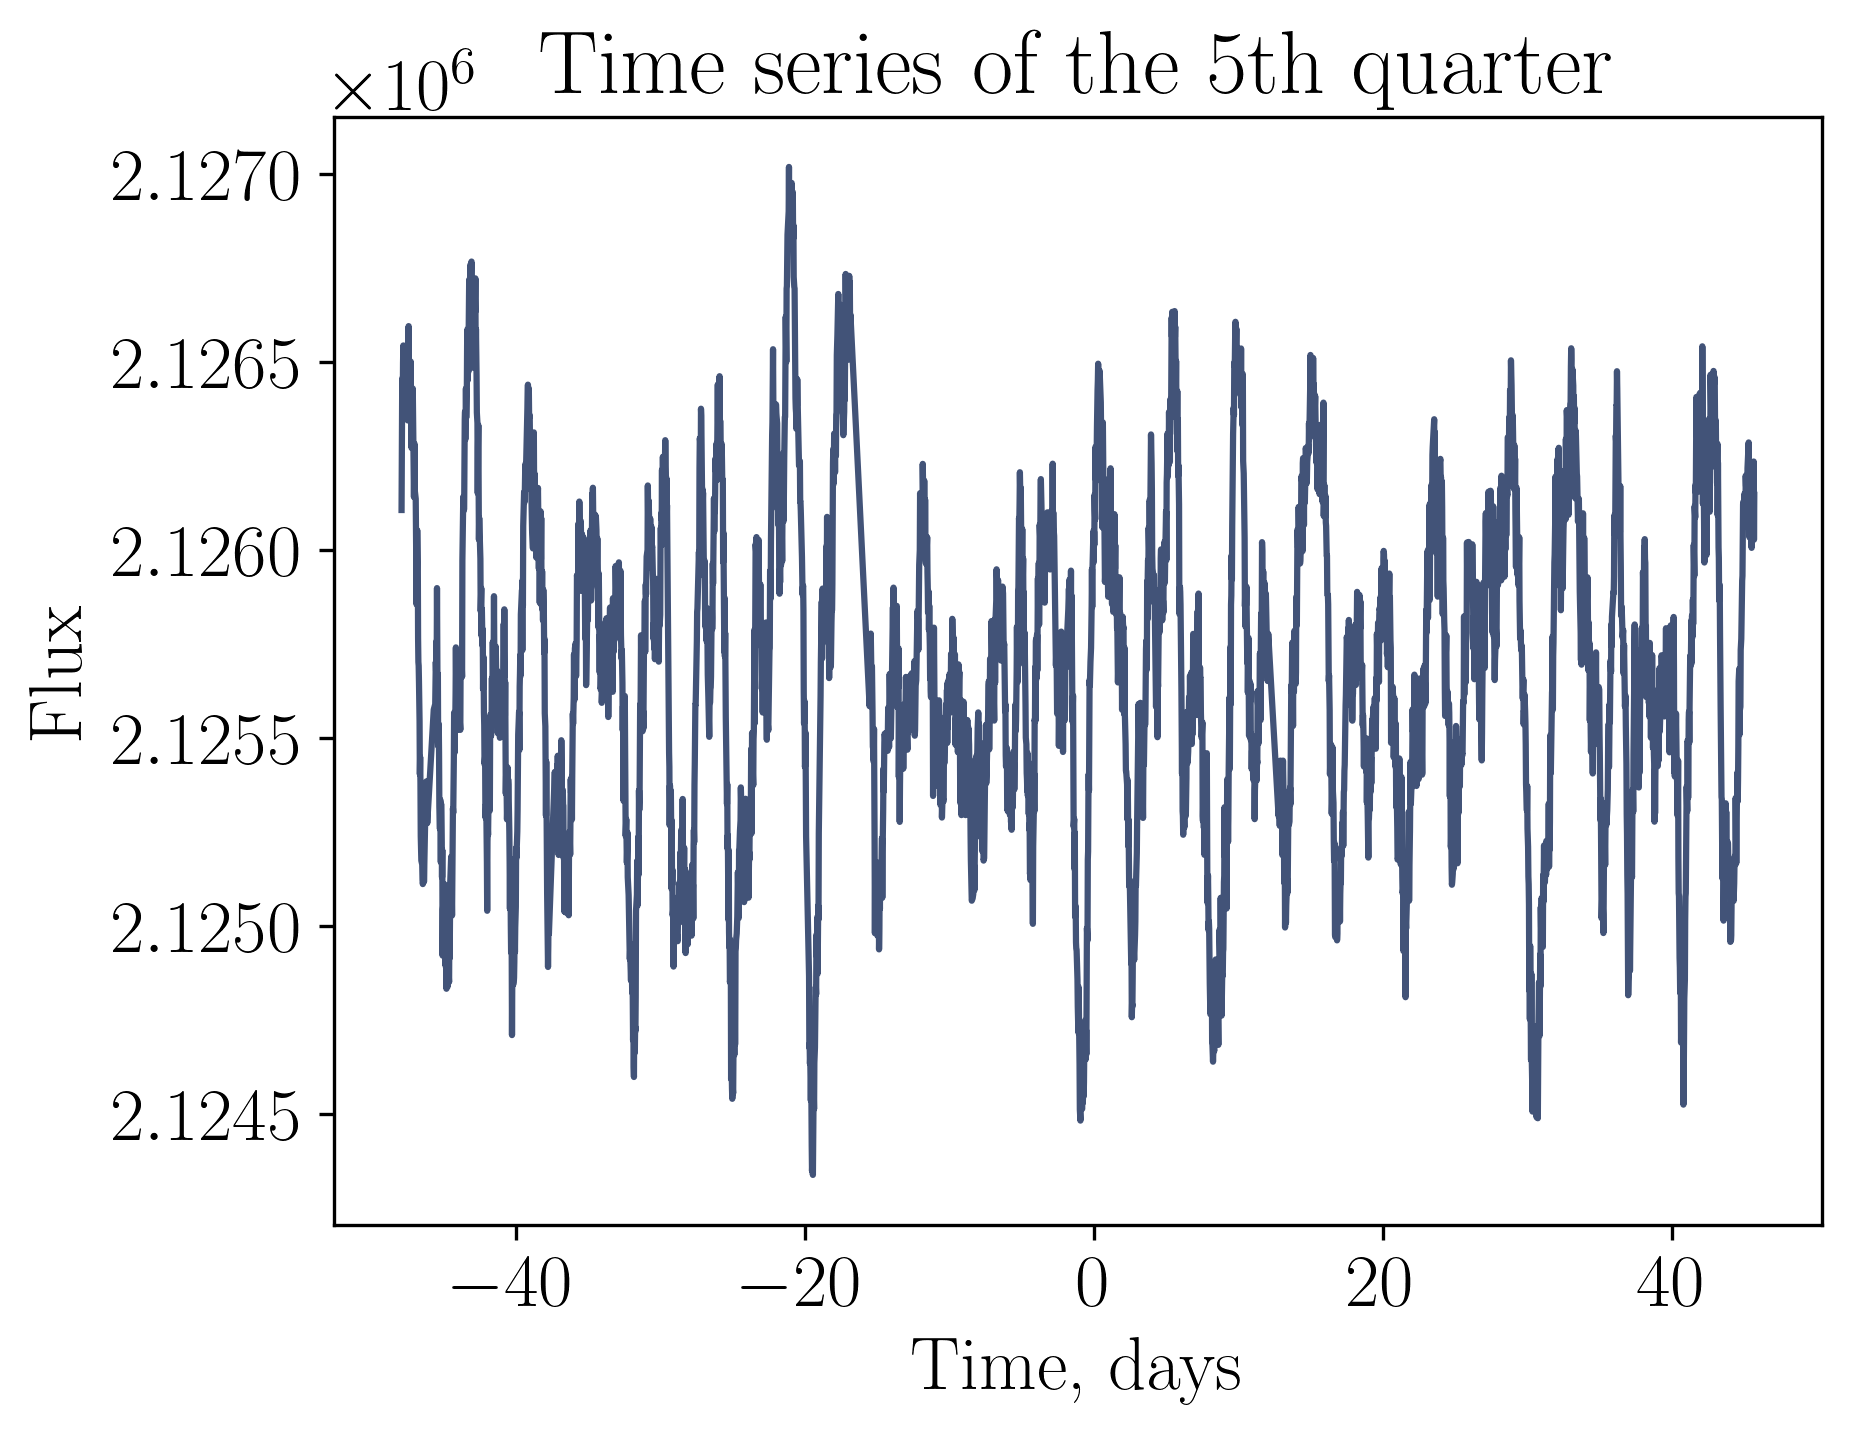

In [11]:
close()
plot(t, f, color)

xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")
title(L"\textrm{Time series of the 5th quarter}");

In [12]:
close()